In [1]:
import psycopg2
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from textblob import blob, Blobber, TextBlob, Sentence, Word, WordList, tokenizers, sentiments, taggers, parsers
#import keras

In [2]:
con = psycopg2.connect(dbname="skillsdb",host=""
                ,port="",user="", password="")
curs = con.cursor()

In [3]:
pd.read_sql_query('''select count (distinct user_id) from cv''',con)

,count
0,4863


In [40]:
# import all data from redshift and insert into a dataframe

data = pd.read_sql_query('''select distinct cv.user_id, cv_section_attribute.name,
cv.value_char, cv.value_timestamp from cv_section_attribute 
left join cv on cv_section_attribute.id=cv.cv_section_attribute_id''',con)

In [26]:
#data.to_pickle('./data.infer')

In [60]:
data['name'].drop_duplicates().values

array(['name', 'locale', 'title', 'grad_year', 'skill', 'admit_year',
       'summary', 'additional_info', 'school', 'description',
       'work_location', 'headline', 'degree', 'resume_link', 'company',
       'links', 'award', 'publication', 'start_date', 'email', 'phone',
       'end_date'], dtype=object)

In [41]:
# include specific CV attributes

headings = ['locale','name','summary','headline','degree','school','company', 'title',
            'work_location','description', 'award', 'publication', 'additional_info', 
            'skill']

data = data[data['name'].isin(headings)]
data.head()

,user_id,name,value_char,value_timestamp
0,1.837377e+11,name,Assistant Teacher,NaT
1,1.837377e+11,locale,"Hilliard, OH",NaT
2,1.837377e+11,title,Hourly Shift Manager,NaT
3,7.614795e+11,locale,"Springfield, OH",NaT
5,7.614795e+11,skill,"Check in / Check out, scheduling, consults, in...",NaT


In [42]:
## load nltk stopwords, tokenization parameters

import string
from nltk.stem.porter import PorterStemmer

stopWords = stopwords.words('english')

tokenizer_prefs = {
    'tokenizer' : nltk.tokenize.PunktSentenceTokenizer(),
#     'token_format' : 'lemma',
    'token_format' : 'stem',
    'spell_correct' : False,
    'np_extract': None,
    'pos_tagger': None,
    'analyzer': None,
    'classifier': None, 
    'clean_html': False
}

stemmer = PorterStemmer()

In [338]:
def clean_data(data, **kwargs):
    '''
    Cleans text data by:
    1.  force lowercase
    2.  remove non-ascii chars
    3.  standardize whitespace
    4.  remove digits
    5.  remove control characters
    6.  remove URL patterns
    '''
    df = data.copy()
#     translator= str.maketrans({a:None for a in ' '.join(stopWords)})    
#     translator=str.maketrans('','',string.punctuation)
#     translator=str.maketrans('','',' '.join(stopWords))
    
    # remove non-ascii chars
    try:
        df['value_char'] = df['value_char'].dropna().map(lambda x: "".join(i for i in x.strip() if ord(i)<128))
#         df['value_char'] = df['value_char'].dropna().map(lambda x: [i for i in x.strip() if i not in stopWords])
#         df['value_char'] = data['value_char'].dropna().map(lambda x: x.translate(translator))
    except UnicodeDecodeError:
        print(UnicodeDecodeError)
        df['value_char'] = df['value_char'].dropna().map(lambda x: x.strip())


    url_pattern = "((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?"

    re_URL = re.compile(url_pattern)
#     re_TAG = re.compile("(<[phl]>)", re.IGNORECASE)
    re_WS = re.compile("/[^\S\n]/")
#     re_DIGIT = re.compile("\d")
    re_CTRL = re.compile("[\x00-\x11\x03-\x1F]+")
    re_HI = re.compile("[\x80-\xFF]+")
    re_NWC = re.compile("[!;<>?{}\/~`#=@#$%^&*()_+]")
    
    df['value_char'] = df['value_char'].map(lambda x: re_HI.sub(' ', x) if type(x) == str else None)
    df['value_char'] = df['value_char'].map(lambda x: re_CTRL.sub(' ', x) if type(x) == str else None)
    df['value_char'] = df['value_char'].map(lambda x: re_URL.sub(' ', x) if type(x) == str else None)
#     data[prefix] = data[prefix].map(lambda x: re_DIGIT.sub(' ', x))
    df['value_char'] = df['value_char'].map(lambda x: re_WS.sub(' ', x) if type(x) == str else None)        
    df['value_char'] = df['value_char'].map(lambda x: re_NWC.sub(' ', x) if type(x) == str else None)
    

    # create a blon using TextBlob
    token_format = kwargs['token_format']
    tokenizer = kwargs['tokenizer']
    pos_tagger = kwargs['pos_tagger']
    analyzer = kwargs['analyzer']
    classifier = kwargs['classifier']
    np_extract = kwargs['np_extract']
    
    df['value_char'] = df['value_char'].dropna().map(lambda l: TextBlob(l.strip(),
                                          tokenizer=tokenizer,
                                           np_extractor=np_extract,
                                           pos_tagger=pos_tagger,
                                           analyzer=analyzer) if l is not None else None)
    df['value_char'] = df['value_char'].dropna().map(lambda x: x.lower())

    df_sentences = df.copy()
    # tokenize the document into sentences from blob object
    df_sentences['value_char'] = df_sentences['value_char'].dropna().map(lambda s: list(s.sentences if s is not None else None))
    
    df_words = df_sentences.copy()
    # tokenize each sentence into words
#     df_words = df_sentences['value_char'].map(lambda l: map(lambda w: w.strip().words if w is not None and len(w)>1 else None, l))
    #tokenize sentence into words and remove none vaues and single letters
    df_words['value_char'] = df_words['value_char'].dropna().map(lambda l: list(w.strip().words for w in l if w is not None and len(w)>1))
    # remove stopwords
    if token_format == 'stem':
        df_words['value_char'] = df_words['value_char'].dropna().map(lambda i: list(stemmer.stem(k.lower()) for j in i for k in j if not k.lower() in stopWords))
    else:
        df_words['value_char'] = df_words['value_char'].dropna().map(lambda i: list(k.lower() for j in i for k in j if not k.lower() in stopWords))
    #    df_words['value_char'] = df['value_char'].map(lambda w: w.words if w is not None else None)    
#     if token_format == 'stem':
#         df_words['value_char'].map(lambda l: list(stemmer.stem(w) for w in l if type(w) == str))

    
    return df, df_words, df_sentences

In [339]:
df, df_words, df_sentences = clean_data(data, **tokenizer_prefs)

In [25]:
# from multiprocessing import Pool
# from multiprocessing.dummy import Pool as ThreadPool

# pool = ThreadPool()

In [11]:
''' 
create a dataframe for each cv attribute, and merge all these dataframes together
to create a dataframe with attributes as the headings
'''

df_all_columns = pd.DataFrame()
for i, heading in enumerate(headings):
    globals()['cv_'+str(heading)] = df[df['name'] == str(heading)][['user_id','value_char']]
    if i == 0:
        pass
    if i == 1:
        df_all_columns = globals()['cv_'+str(headings[0])].merge(globals()['cv_'+str(headings[1])], how='outer', on='user_id') 
    if i > 1 and i < 13:
        df_all_columns = df_all_columns.merge(globals()['cv_'+str(headings[i])], how='outer', on='user_id') 
df_all_columns.columns = ['user_id']+headings[0:13]
df_all_columns.head(3)

,user_id,locale,name,summary,headline,degree,school,company,title,work_location,description,award,publication,additional_info
0,2.858701e+11,"(L, o, n, d, o, n)","(T, e, a, c, h, i, n, g, , A, s, s, o, c, i, ...","(H, a, v, i, n, g, , w, o, r, k, e, d, , a, ...","(R, e, s, e, a, r, c, h, ,, , W, r, i, t, i, ...","(P, h, D, , d, i, , H, i, s, t, o, r, y)","(U, n, i, v, e, r, s, i, t, y, , o, f, , E, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.990834e+11,"(L, o, n, d, o, n)","(R, e, g, i, s, t, e, r, e, d, , M, a, n, a, ...",NaN,"(R, e, g, i, s, t, e, r, e, d, , M, a, n, a, ...",NaN,"(C, h, a, r, t, e, r, e, d, , M, a, n, a, g, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.076034e+11,"(L, o, n, d, o, n)","(F, r, e, e, l, a, n, c, e, , G, r, a, p, h, ...",NaN,NaN,"(P, h, D, , i, n, , A, r, t, , , p, r, a, ...","(L, a, n, c, a, s, t, e, r, , U, n, i, v, e, ...","(L, a, n, c, a, s, t, e, r, , U, n, i, v, e, ...","(F, r, e, e, l, a, n, c, e, , G, r, a, p, h, ...","(L, a, n, c, a, s, t, e, r, , U, n, i, v, e, ...","(K, e, y, , r, e, s, p, o, n, s, i, b, i, l, ...",NaN,NaN,"(L, a, n, g, u, a, g, e, , a, n, d, , I, T, ..."


In [24]:
 model_name = 'train_model'
 # Set values for various word2vec parameters
 num_features = 300    # Word vector dimensionality                      
 min_word_count = 40   # Minimum word count                        
 num_workers = 8       # Number of threads to run in parallel
 context = 10          # Context window size
 # downsampling = 1e-3   # Downsample setting for frequent words
 if not os.path.exists(model_name): 
     # Initialize and train the model (this will take some time)
     model = word2vec.Word2Vec(sentences, workers=num_workers, \
                 size=num_features, min_count = min_word_count, \
                 window = context, sample = downsampling)

     # If you don't plan to train the model any further, calling 
     # init_sims will make the model much more memory-efficient.
     model.init_sims(replace=True)

     # It can be helpful to create a meaningful model name and 
     # save the model for later use. You can load it later using Word2Vec.load()
     model.save(model_name)
 else:
     model = Word2Vec.load(model_name)

In [341]:
# Load wiki_dbow doc2vec model

import gensim
from gensim.models import Doc2Vec
import multiprocessing

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1

# model = Doc2Vec.load('./enwiki_dbow/doc2vec.bin')
# model.syn0.shape

In [256]:
# model = Doc2Vec(df['value_char'].dropna(), workers=8)
# model.save('trained_docv2ec.bin')

In [466]:
# model.save(fname)
model_cv = Doc2Vec.load('trained_docv2ec.bin')

In [ ]:
# def get_feature_vecs(cv_values, model, num_features=300):
#     """
#     Calculate feature vectors for all values
#     """
#     counter = 0
#     feature_vecs = np.zeros((len(cv_values.drop_duplicates()),num_features), dtype='float32')  # pre-initialize (for speed)
# #     feature_vecs = []
    
#     for value in cv_values:
#         feature_vecs[counter] = model.infer_vector(value)
#         counter = counter + 1
#     return feature_vecs

In [467]:
def get_feature_vecs(df, model, num_features=300):
    """
    Calculate feature vectors for all values
    """
#     counter = 0
#     feature_vecs = np.zeros((len(cv_values.drop_duplicates()),num_features), dtype='float32')  # pre-initialize (for speed)
#     feature_vecs = []
    df_doc_vectors = df[['user_id','name','value_char']].dropna(subset=['value_char'], how='all').copy()
    df_doc_vectors['doc_vector'] = ''
    for index, value in df_doc_vectors.iterrows():
        df_doc_vectors.set_value(index, 'doc_vector', model.infer_vector(value['value_char']))
#         counter = counter num_features+ 1
    return df_doc_vectors

In [475]:
df_doc_vectors = get_feature_vecs(df, model_cv,100)

In [123]:
# df_doc_vectors.to_pickle('./df_doc_vectors.infer')

In [476]:
df_groupby_user_id = df_doc_vectors.groupby(by='user_id')
y_train = df_groupby_user_id.apply(lambda x: x[(x['name'] == 'title') |
                                               (x['name'] == 'name') | 
                                               (x['name'] == 'company')]['doc_vector'].mean())
y_train_df = pd.DataFrame(y_train).reset_index()
y_train_df.columns = ['user_id', 'vectors']

In [477]:
x_train = df_groupby_user_id.apply(lambda x: x[(x['name'] == 'skill') |
                                               (x['name'] == 'degree') | 
                                               (x['name'] == 'award') |
                                              (x['name'] == 'publication') |
                                                (x['name'] == 'locale')
                                              ]['doc_vector'].mean())
x_train_df = pd.DataFrame(x_train).reset_index()
x_train_df.columns = ['user_id', 'vectors']

In [484]:
y_train_vectors = np.array([model_cv.docvecs.most_similar([i], topn=1) for i in y_train_df['vectors']])

In [485]:
x_train_vectors = np.array([i for i in y_train_df['vectors']])

In [486]:
x_train_vectors.shape

(4863, 100)

In [487]:
# model_cv.docvecs.most_similar([y_train_df['vectors'][30]], topn=20)

In [488]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100, n_jobs = -1)

In [492]:
y_train_normalized = np.array([i[0][0][0] for i in y_train_vectors])

In [499]:
len(y_train_normalized)

4863

In [458]:
np.array(x_train_df['vectors']).reshape(1, -1).shape

(1, 4863)

In [500]:
print("Fitting a random forest to labeled training data...")
forest = forest.fit(x_train_vectors, y_train_normalized)

Fitting a random forest to labeled training data...


In [510]:
forest.predict(model_cv.infer_vector('I hava a phd').reshape(1, -1))

array(['side'],
      dtype='<U27')

In [250]:
from sklearn.cluster import KMeans

KMeans(n_clusters=4, random_state=0).fit(df_doc_vectors_reshaped)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [11]:
## generate a list of cv summaries with the respective user_ids from the dataframe

heads = []
indicies = []

for i, row in data.iterrows():
    if row[1] == 'summary':
        heads.append([row[0], row[2]])
        indicies.append(row[0])

heads.sort(key=lambda x: x[0])
heads[:2]

[[100455018610.0,
  ' Determined selfmotivator highly organised and reliable Experienced and innovative in various accounting procedures High personal integrity and able to relate to and create trust in all Highly articulate and confident able to motivate and communicate to achieve exceptional business performances Persistent and flexible approach to the mutually beneficial achievement of company business plans Friendly approachable'],
 [100508885550.0,
  'I am a Masters student studying Zoology at the University of Manchester Prior to university I was under full time employment for AP Moller Maersk  a multinational shipping company Here I gained a plethora of experience in negotiating and organizational skills systems and business development a firm sense of responsibility and capacity to work hard under pressure I have been tutoring students in GCSE and A level biology for almost 12 months which has given me a firm grasp on lesson planning and effective communication']]

In [12]:
## interate through the dataframe and create a list of cv attributes of each cv with the respective user_ids

from itertools import groupby

cv_attributes = []

for i, row in data.iterrows():
    if row[0] in indicies and row[1] != 'summary' and row[2] is not None:
        cv_attributes.append([int(row[0]), row[1] + ': ' + row[2]])
        
cv_attributes.sort(key=lambda x: x[0])
        
description = [[user_id, [cv_field[1] for cv_field in cv_fields
                         ]] for user_id, cv_fields in groupby(cv_attributes, 
                                                              lambda x: x[0])]
# description= [user_id for user_id, cv_fields in groupby(cv_attributes, lambda x: int(x[0]))]
desc = [[p[0], ', '.join(p[1][0:])] for p in description]
# desc.sort(key=lambda x: x[0])
# desc[:5]
desc.sort()
desc[:2]

[[100455018610,
  'locale: Kirkby, name: Finance Analyst, headline: Finance Analyst  CPI Card Group  UK Ltd, degree: BA en Business Information Systems and Combined Studies, school: Liverpool John Moores University'],
 [100508885550,
  'name: Personal Science Tutor GCSE, locale: Manchester, headline: Presonal Science Tutor GCSE  TutorFuture, degree: MSci di Zoology, school: The University of Manchester']]

In [13]:
user_ids = []
for i in desc:
    user_ids.append(i[0])

## can use the list indicies insted!
user_ids.sort()

desc_data = []
heads_data = []

for i, u_id in enumerate(user_ids):
    if desc[i][0] == u_id and heads[i][0] == u_id:
        desc_data.append(desc[i][1])
        heads_data.append(heads[i][1])

Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [14]:
FN = 'vocabulary-embedding'

In [15]:
seed = 42

In [16]:
vocab_size = 40000

In [17]:
embedding_dim = 100

In [18]:
lower = True # dont lower case the text

# read tokenized headlines and descriptions

In [279]:
# if lower:
#     heads_data = [h.lower() for h in heads_data]

In [278]:
# if lower:
#     desc_data = [h.lower() for h in desc_data]

In [22]:
i=0
heads_data[i]

' determined selfmotivator highly organised and reliable experienced and innovative in various accounting procedures high personal integrity and able to relate to and create trust in all highly articulate and confident able to motivate and communicate to achieve exceptional business performances persistent and flexible approach to the mutually beneficial achievement of company business plans friendly approachable'

In [23]:
desc_data[i]

'locale: kirkby, name: finance analyst, headline: finance analyst  cpi card group  uk ltd, degree: ba en business information systems and combined studies, school: liverpool john moores university'

In [24]:
# keywords[i]

In [25]:
len(heads_data),len(set(heads_data))

(2273, 2263)

In [26]:
len(desc_data),len(set(desc_data))

(2273, 2273)

# build vocabulary

In [28]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split() if not w in stopWords)
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [29]:
vocab, vocabcount = get_vocab(heads_data+desc_data)

most popular tokens

In [30]:
print(vocab[:50])
print('...',len(vocab))

['data', 'business', 'skill:', 'test', 'project', 'management', 'analysis', 'description:', 'testing', 'using', 'company:', 'work_location:', 'title:', 'requirements', 'experience', 'team', 'system', 'development', 'process', 'degree:', 'school:', 'ms', 'skills', 'sql', 'new', 'work', 'university', 'name:', 'analyst,', 'locale:', 'systems', 'software', 'support', 'design', 'quality', 'worked', 'technical', 'user', 'developed', 'research', 'working', 'application', 'headline:', 'reports', 'tools', 'various', 'analyst', 'customer', 'including', 'cases']
... 57149


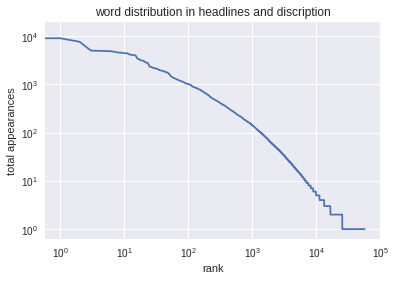

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [32]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [33]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [34]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [35]:
from keras.utils.data_utils import get_file
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}

In [36]:
glove_name

'/home/ubuntu/.keras/datasets/glove.6B.100d.txt'

In [37]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = (glove_n_symbols[0].split()[0])
glove_n_symbols

'400000'

In [38]:
glove_index_dict = {}
glove_embedding_weights = np.empty((int(glove_n_symbols), embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [39]:
glove_embedding_weights.std()

0.040815727600190289

In [40]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [41]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514 std 0.0408138249575
number of tokens, in small vocab, found in glove and copied to embedding 20256 0.5064


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [42]:
glove_thr = 0.5

In [43]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [44]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 3541


manually check that the worst substitutions we are going to do are good enough

In [45]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

0.501071989383 opp => etc
0.500790394178 giga => rbc
0.500646643643 formato => tsf
0.500554290739 picard => noe
0.500385972636 katy => travis
0.500356602128 infesting => digitising
0.50025490251 cage => mask
0.500204880576 thermography => microstrip
0.500160348413 qubit => exciton
0.500085234816 enoch => burroughs


build a lookup table of index of outside words to index of inside words

In [46]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [51]:
Y = [[word2idx[token] for token in headline.split() if not token in stopWords] for headline in heads_data]
len(Y)

2273

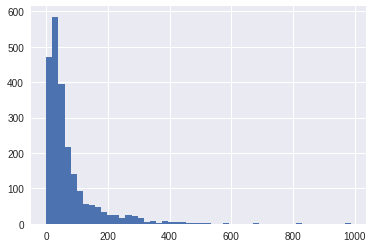

In [52]:
plt.hist(list(map(len,Y)),bins=50);

In [53]:
X = [[word2idx[token] for token in d.split() if not token in stopWords] for d in desc_data]
len(X)

2273

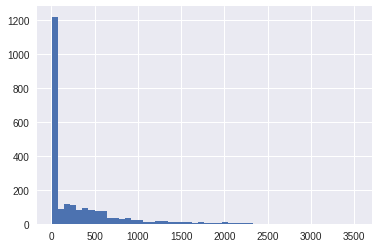

In [54]:
plt.hist(list(map(len,X)),bins=50);

In [55]:
import pickle
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [56]:
# import pickle
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)